In [2]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [3]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

In [8]:
cat_output_name = output_dir+'cat_out_nonir_il_formass.fits'
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
cat_v_name = '/Volumes/LejaySSD/v11_cats/COSMOS_v11_6bands_v220127.fits'
col_list = "'RA DEC ZPHOT'"

In [5]:
combined_cat_name = cat_output_name.replace('.fits','c20added.fits')

# 3-catalog match
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
       in1='+cat_output_name+' values1="RA DEC" \
       in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
       in3='+cat_v_name+' values3="RA DEC" \
       out='+ combined_cat_name+' icmd3="keepcols '+col_list+'" '
os.system(cmd)
    
cat_original = Table.read(cat_output_name)
cat_matched = Table.read(combined_cat_name)
arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
cat_matched = cat_matched[ind]
cat_matched = cat_matched[cat_matched['lp_zPDF']>0]
cat_matched = cat_matched[cat_matched['MAG_AUTO_CH1_CORR']<99]
cat_matched = cat_matched[cat_matched['MAG_AUTO_CH2_CORR']<99]
cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med'])]

/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:988: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


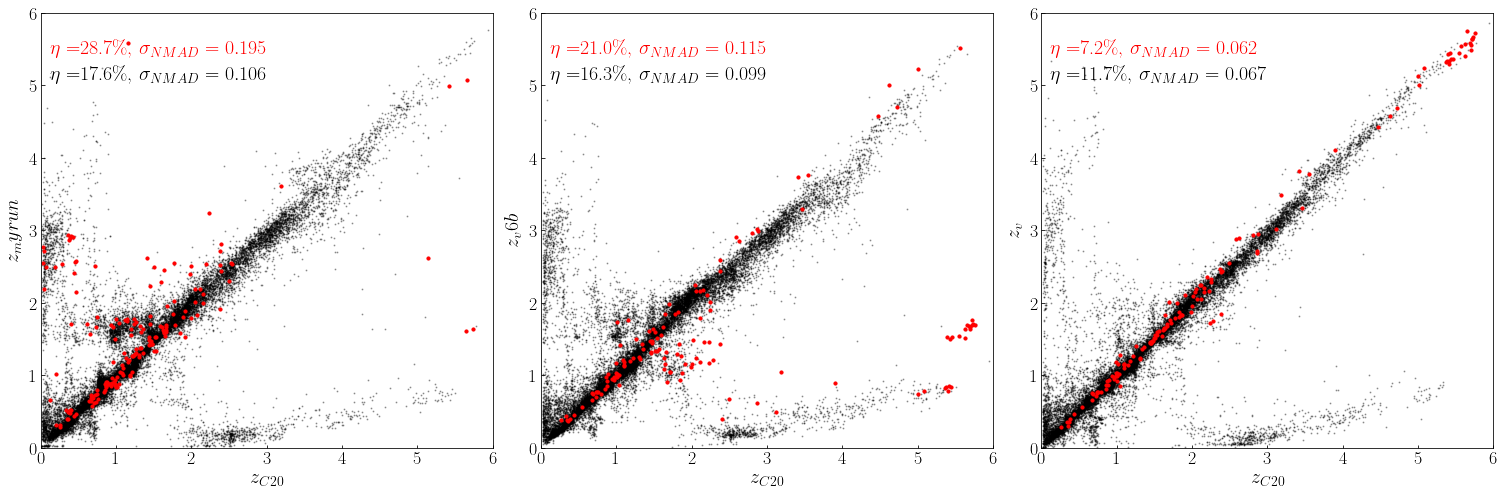

In [10]:
# redshift comparison
outlier_factor = 0.15
massive_cut = 11.3
cat = cat_matched

fig, axs = plt.subplots(1, 3, figsize = (21, 7),sharex=True)
colors= ['red','red']
z_names_toshow = ['$z_myrun$','$z_v6b$','$z_v$']
for j,z_type in enumerate(['Z_ML','ZPHOT_3','ZPHOT_1']):
    massive_cond_myrun = cat['MASS_MED_massrun']>massive_cut
    my_massive = cat[massive_cond_myrun]
    massive_cond_v = cat['MASS_MED_old']>massive_cut # mass_med_old is mas derived from full photometry
    my_massive_v = cat[massive_cond]
    c20_massive = cat[cat['lp_mass_med']>massive_cut]
        
    # plot
    axs[j].scatter(cat['lp_zPDF'],cat[z_type],s=1, color='k',alpha=0.3)
    if z_type=='Z_ML':
        axs[j].scatter(cat[massive_cond]['lp_zPDF'],cat[massive_cond][z_type],s=10, color='r')
    else:
        axs[j].scatter(cat[massive_cond_v]['lp_zPDF'],cat[massive_cond_v][z_type],s=10, color='r')
            
    num_outliers = len(cat[abs(cat['lp_zPDF']-cat[z_type])>outlier_factor*(1+cat['lp_zPDF'])])
    num_outliers_massive = len(cat[massive_cond][abs(cat[massive_cond]['lp_zPDF']-cat[massive_cond][z_type])>outlier_factor*(1+cat[massive_cond]['lp_zPDF'])])
    deltaz = np.array(cat[z_type]-cat['lp_zPDF'])
    deltaz_massive = np.array(cat[massive_cond][z_type]-cat[massive_cond]['lp_zPDF'])
    sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
    sigma_massive = 1.4826*np.median(abs(deltaz_massive - np.median(deltaz_massive)))
    
    axs[j].annotate('$\eta=$'+str(round(num_outliers/len(cat)*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
    axs[j].annotate('$\eta=$'+str(round(num_outliers_massive/len(cat[massive_cond])*100,1))+'\%, $\sigma_{NMAD}='+str(round(sigma_massive,3))+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='r')   
    axs[j].set_xlabel('$z_{C20}$',fontsize=20)
    axs[j].set_ylabel(z_names_toshow[j],fontsize=20)
    axs[j].set_xlim([0,6])
    axs[j].set_ylim([0,6])
    
plt.tight_layout()